In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from pathlib import Path

from utilities import create_dategenerator

In [2]:
# Model directories
model_dir1 = "SuperResolution"
model_dir2 = "Surrogate"

# Define the date range of the whole simulation
start_date = datetime(2018, 1, 1, 0, 0)
end_date = datetime(2019, 12, 31, 23, 0)

# Define time_step and time_step_type of the simulation
time_step_type = "hrs"
time_step = 1

variables = ["Hs", "Tm02", "Dir"]

# Define the range of the test data
sample_start = 8761
sample_end = 17496


# Define how many and which data points should be displayed
nmin = 17280 -24*2
nmax = 17280 + 24*2  # Two days around an extreme event

# Define the point where the time series is extracted (in pixel)
xi = 86
yi = 104

# Save the figure?
save = True

In [3]:
# Define help function to create a generator that outputs a datetime object for the given time range (always needed)
if time_step_type == "hour":
    const = int(24/time_step)
    
    def daterange(start_date, end_date):
        for n in range(const*int((end_date - start_date).days)):
            yield start_date + n*timedelta(hours=time_step)

else:
    const = int(60/time_step * 24)
    
    def daterange(start_date, end_date):
        for n in range(const*int((end_date - start_date).days)):
            yield start_date + n*timedelta(minutes=time_step)         

In [4]:
# Load all the dates
daterange = create_dategenerator(time_step, time_step_type)
dates = list(daterange(start_date, end_date))

def load_time_series(variables, model_dir):
    prediction = []
    reference = []
    LR_reference = []

    # Load the LR and HR images
    for i, var in enumerate(variables):
        # Load saved array, if calculation was already done before
        path_dir = Path(f"Data/Time_Series/{model_dir}")
        path_arr = path_dir / f"Var_{var}_posxy_{xi}_{yi}.npy"

        arr = np.load(path_arr)

        prediction.append(arr[0,:])
        reference.append(arr[1,:])
        LR_reference.append(arr[2,:])
    
    return prediction, reference, LR_reference

In [5]:
prediction1, reference, LR_reference = load_time_series(variables, model_dir1)
prediction2, _, _ = load_time_series(variables, model_dir2)

# Time series Plot

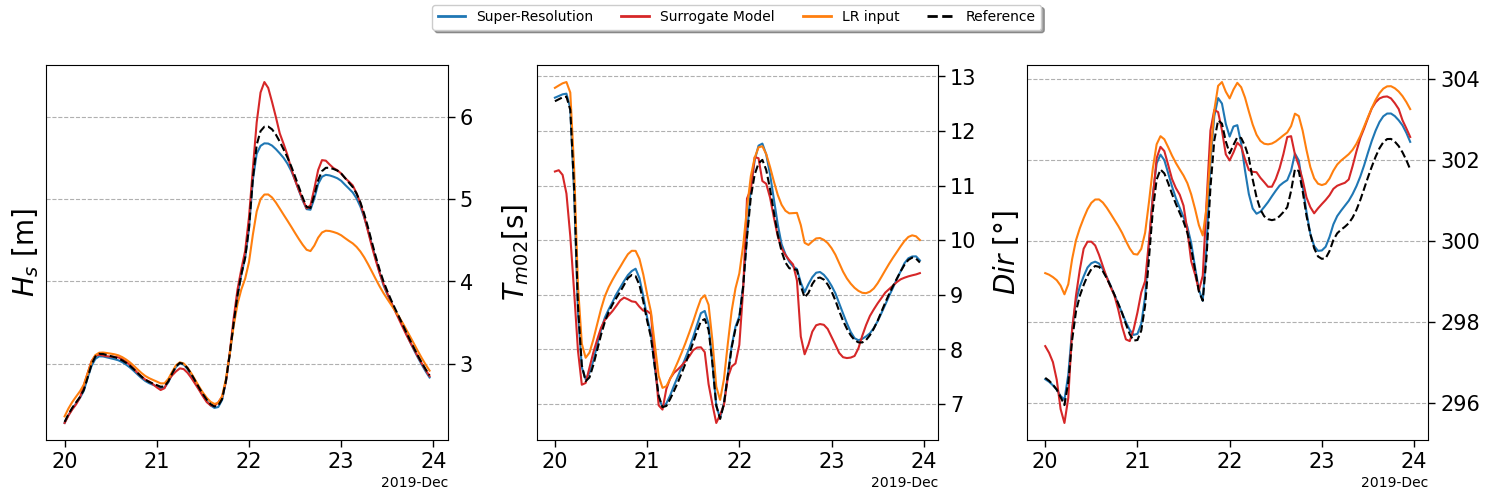

In [6]:
# Some plotting constants for the ticks
LABELSIZE = 15
LEGENDFONTSIZE = 10
LENGTH = 5.0
WIDTH= 1.0

ylabels = [r"$H_s$ [m]",
           r"$T_{m02}$[s]",
           r"$Dir$ [°]"]

fig, axs = plt.subplots(1, 3, figsize=(15,5))
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

n1 = nmin - sample_start
n2 = nmax - sample_start

for nvar in range(len(variables)):

    lower = np.nanmin(reference[0])
    upper = np.nanmax(reference[0])


    axs[nvar].xaxis.set_major_locator(locator)
    axs[nvar].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[nvar].xaxis.set_major_formatter(formatter)
    axs[nvar].plot(dates[nmin:nmax], prediction1[nvar][n1:n2],
                   color="tab:blue", label="Super-Resolution")
    axs[nvar].plot(dates[nmin:nmax], prediction2[nvar][n1:n2],
                   color="tab:red", label="Surrogate Model")
    axs[nvar].plot(dates[nmin:nmax], LR_reference[nvar][n1:n2],
                   color="tab:orange", label="LR Input")
    axs[nvar].plot(dates[nmin:nmax], reference[nvar][n1:n2], c="black", ls="--", label="Reference")
    axs[nvar].grid(True, axis="y", ls="--")
    axs[nvar].set_ylabel(ylabels[nvar], size=20)
    axs[nvar].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                         labelleft=False, labeltop=False, labelright=True, labelbottom=True)
    axs[nvar].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


legend_elements = [Line2D([0], [0], color='tab:blue', label='Super-Resolution',
                          lw=2, linestyle="-"),
                   Line2D([0], [0], color='tab:red', label='Surrogate Model',
                          lw=2, linestyle="-"),
                   Line2D([0], [0], color='tab:orange', label='LR input',
                          lw=2, linestyle="-"),
                   Line2D([0], [0], color='black', label='Reference',
                          lw=2, linestyle="--")]    

fig.legend(handles=legend_elements, loc=(0.29, 0.94),
       fancybox=True, shadow=True, ncol=4, fontsize=LEGENDFONTSIZE)

plt.tight_layout()

fig.subplots_adjust(top=0.88)

fdir = Path("Plots")
fname = "TimeSeries.png"

if save:
    fdir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fdir / fname)
                         
plt.show()